In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tree_based_models import (
    model_selection_using_kfold_surv,
    model_selection_using_kfold,
    get_model,
)
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxPHSurvivalAnalysis, IPCRidge, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from feature_engineering import (
    one_hot_aggregate,
    add_cytogenetic_features,
    create_molecular_feat,
)

from sksurv.util import Surv
from deepsurv import model_selection_using_kfold_deepsurv, DeepSurv, train_deepsurv

## Data Loading

In [2]:
# Clinical Data
clinical_train = pd.read_csv("data/X_train/clinical_train.csv")
clinical_test = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
molecular_train = pd.read_csv("data/X_train/molecular_train.csv")
molecular_test = pd.read_csv("data/X_test/molecular_test.csv")

target_train = pd.read_csv("data/X_train/target_train.csv")

# Preview the data
clinical_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [3]:
train = pd.concat(
    [
        clinical_train.set_index("ID"),
        target_train.set_index("ID"),
    ],
    axis=1,
)
train = train[~train["OS_YEARS"].isna()]
train.head()

,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,OS_YEARS,OS_STATUS
ID,,,,,,,,,,
P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.115068,1.0
P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",4.928767,0.0
P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",2.043836,0.0
P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",2.476712,1.0
P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",3.145205,0.0


## Baseline using simple features

Define base features

In [4]:
target = "OS_YEARS"
base_features = ["BM_BLAST", "WBC", "HB", "PLT"]
model_type = "cat"

Model not censored CATBoosting

Fold 1 - IPCW C-index (Train: 0.6995 | Test: 0.6638)
Fold 2 - IPCW C-index (Train: 0.7006 | Test: 0.6631)
Fold 3 - IPCW C-index (Train: 0.6947 | Test: 0.6942)
Fold 4 - IPCW C-index (Train: 0.6997 | Test: 0.6623)
Fold 5 - IPCW C-index (Train: 0.7095 | Test: 0.6416)
Fold 6 - IPCW C-index (Train: 0.7018 | Test: 0.6682)
IPCW C-index: 0.6655 (± 0.0154) [Min: 0.6416 ; Max: 0.6942]

Top 10 important features:
['PLT', 'HB', 'BM_BLAST', 'WBC']


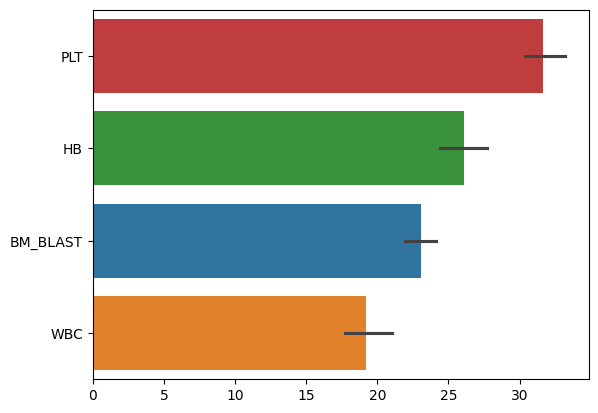

In [ ]:
model_selection_using_kfold(
    data=train.reset_index(),
    target=target,
    features=base_features,
    model_type=model_type,
    feat_engineering=None,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    log=False,
)

## Feature Engineering 

Define some feature engineering : 
- Molecular data One Hot Encoding
- Decode cytogenetic data
- Add Molecular Mutations informations

In [5]:
def feat_engineering(
    data: pd.DataFrame,
    molecular_data: pd.DataFrame,
    fill_not_molecular=False,
) -> tuple[pd.DataFrame, list]:
    """Apply domain-specific feature engineering for DeepSurv."""

    # Identify patients with no molecular data
    ids_not_molecular = [
        pid for pid in data.index.unique() if pid not in molecular_data["ID"].unique()
    ]
    not_molecular = data[data.index.isin(ids_not_molecular)]

    # === 1. Molecular Features ===
    # Aggregates mutation-based numerical features (e.g., count, mean VAF, length)
    data, molecular_feat = create_molecular_feat(
        data=data, molecular_data=molecular_data
    )

    # === 2. Cytogenetic Features ===
    # Adds features describing cytogenetic abnormalities (e.g., complex karyotype)
    data, col_clinical = add_cytogenetic_features(data)

    # === 3. One-Hot Encoding of Molecular Categories ===
    # EFFECT: mutation effect types (e.g., missense, frameshift)
    data, categories = one_hot_aggregate(molecular_data, data, "EFFECT")

    # CHR: chromosome-level distribution of mutations
    data, chromosomes = one_hot_aggregate(
        molecular_data, data, "CHR", fillna_value="no_chr"
    )

    # GENE: gene-level presence/absence indicators
    data, genes = one_hot_aggregate(
        molecular_data, data, "GENE", fillna_value="no_gene"
    )

    # Collect all generated feature names
    new_feats = list(col_clinical) + list(categories) + list(chromosomes) + list(genes)

    # Recompute cytogenetic features for non-molecular patients
    not_molecular, _ = add_cytogenetic_features(not_molecular)

    # Fill missing molecular features with 0 for non-molecular patients
    if fill_not_molecular:
        data = pd.concat([data, not_molecular])
        data[
            list(molecular_feat) + list(categories) + list(chromosomes) + list(genes)
        ] = data[
            list(molecular_feat) + list(categories) + list(chromosomes) + list(genes)
        ].fillna(
            0
        )

    return data, new_feats

Add new features to the data

In [6]:
# === Apply Feature Engineering ===
test = clinical_test.set_index("ID").copy()

train, feat_train = feat_engineering(
    data=train, molecular_data=molecular_train, fill_not_molecular=True
)
test, feat_test = feat_engineering(
    data=test, molecular_data=molecular_test, fill_not_molecular=True
)

feats = [ft for ft in feat_test if ft in feat_train]

Define Features

In [7]:
# === Define Model Inputs ===
target = "OS_YEARS"
features = base_features + feats
model_type = "cat"  # Parameters and Model based on previous challenges knowledge tree_based_models/initialise_model.py

Perform Cross Validation

Fold 1 - IPCW C-index (Train: 0.7418 | Test: 0.6801)
Fold 2 - IPCW C-index (Train: 0.7440 | Test: 0.6915)
Fold 3 - IPCW C-index (Train: 0.7419 | Test: 0.7245)
Fold 4 - IPCW C-index (Train: 0.7424 | Test: 0.7124)
Fold 5 - IPCW C-index (Train: 0.7406 | Test: 0.7239)
Fold 6 - IPCW C-index (Train: 0.7437 | Test: 0.7005)
IPCW C-index: 0.7055 (± 0.0164) [Min: 0.6801 ; Max: 0.7245]

Top 20 important features:
['PLT', 'HB', 'BM_BLAST', 'non_synonymous_codon', '21', '17', 'TP53', 'WBC', 'num_monosomies', 'NFE2', 'sex', 'SF3B1', 'ASXL1', 'num_trisomies', '1', 'RUNX1', '20', 'abnormal_fraction', 'stop_gained', 'X']


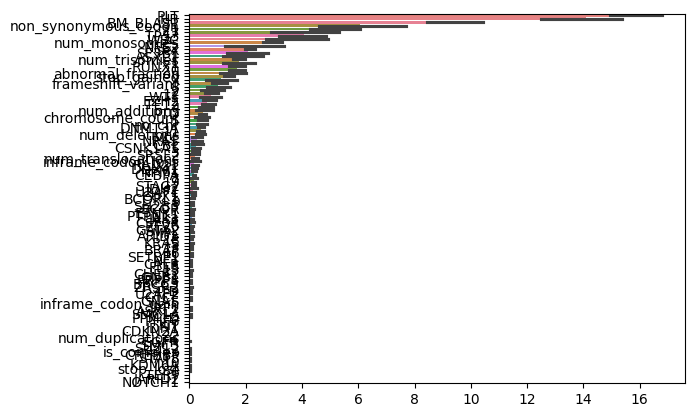

In [ ]:
# === Model Selection with Cross-Validation ===
model_selection_using_kfold(
    data=train.reset_index(),
    target=target,
    features=features,
    model_type=model_type,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    scale=True,
    n_importance=20,
)

## Survival Model

In [8]:
# === Select and Configure Tree-Based Model ===

# Test Random Survival Forest
model_cls = RandomSurvivalForest

model_params = {
    "n_estimators": 150,
    "max_depth": 15,
    "min_weight_fraction_leaf": 0.005,
    "random_state": 42,
}

In [9]:
status = "OS_STATUS"

In [10]:
# === Model Selection via K-Fold Cross Validation ===
model_selection_using_kfold_surv(
    data=train.reset_index(),
    target=target,
    status=status,
    model_cls=model_cls,
    params=model_params,
    features=features,
    feat_engineering=None,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    log=False,
)

Fold 1 - Concordance Index (Train: 0.7729 | Test: 0.6801)
Fold 2 - Concordance Index (Train: 0.7669 | Test: 0.7152)
Fold 3 - Concordance Index (Train: 0.7671 | Test: 0.7295)
Fold 4 - Concordance Index (Train: 0.7694 | Test: 0.7259)
Fold 5 - Concordance Index (Train: 0.7664 | Test: 0.7353)
Fold 6 - Concordance Index (Train: 0.7696 | Test: 0.7095)
Concordance Index: 0.7159 (± 0.0182) [Min: 0.6801 ; Max: 0.7353]
Feature importance not available for this model.


## Deep Surv

In [11]:
# DeepSurv hyperparameters
hidden_layers_sizes = [128, 64]
dropout = 0.4
n_splits = 6
n_epochs = 50
lr = 1e-4
weight_decay = 1e-5

In [12]:
# === Model Selection with Cross-Validation ===
results = model_selection_using_kfold_deepsurv(
    data=train.reset_index(),
    features=features,
    target=target,
    status=status,
    hidden_layers_sizes=hidden_layers_sizes,
    dropout=dropout,
    n_splits=n_splits,
    n_epochs=n_epochs,
    lr=lr,
    weight_decay=weight_decay,
    unique_id="ID",
    device="cpu",
)

/Users/mafaldafrere/miniforge3/envs/torch_max/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fold 1 - IPCW C-index (Train: 0.7703 | Test: 0.7121)
Fold 2 - IPCW C-index (Train: 0.7666 | Test: 0.7157)
Fold 3 - IPCW C-index (Train: 0.7673 | Test: 0.7235)
Fold 4 - IPCW C-index (Train: 0.7620 | Test: 0.7049)
Fold 5 - IPCW C-index (Train: 0.7707 | Test: 0.6909)
Fold 6 - IPCW C-index (Train: 0.7674 | Test: 0.7087)

Concordance Index (Test, IPCW): 0.7093 ± 0.0101 [Min: 0.6909 ; Max: 0.7235]
